In [1]:
from sheet_id.utils.base_utils import generateSheetMaskAnnotation
from sheet_id.utils.eval_utils import evaluate
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

import glob
import math
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from copy import deepcopy

In [2]:
import importlib
import sheet_id.utils.base_utils
importlib.reload(sheet_id.utils.base_utils)

<module 'sheet_id.utils.base_utils' from '/data/mirlab/Workspace/SheetIdentification/sheet_id/utils/base_utils.py'>

# Notehead Detection on DeepScores

In [3]:
from sheet_id.models.FCN import FCN
from sheet_id.utils.loss_functions import softmax_sparse_crossentropy_ignoring_background, softmax_sparse_crossentropy
from sheet_id.utils.metrics import sparse_accuracy_ignoring_background, sparse_accuracy
from sheet_id.utils.dataPreprocessing import splitTrainValidation
from sheet_id.utils.dataGenerator import DataGenerator
from sheet_id.utils.dwd_utils import generateGroundTruthMaps

from keras.layers.convolutional import Conv2D
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

/home/mirlab/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model = FCN(input_shape=(500,500,1), n_classes=124)
input_map = Input(shape=(500,500,1))
output_featuremaps = model(input_map)
energy_output = Conv2D(10,  (1,1), activation='relu', padding='same', name='energy_map')(output_featuremaps)
class_output  = Conv2D(124, (1,1), activation='relu', padding='same', name='class_map')(output_featuremaps)
bbox_output   = Conv2D(2,   (1,1), activation='relu', padding='same', name='bbox_map')(output_featuremaps)
dwd_model = Model(inputs=[input_map], outputs=[energy_output, class_output, bbox_output])
loss_fn = softmax_sparse_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, 
                 epsilon=1e-8, decay=0.0, amsgrad=False)
metrics = []
dwd_model.compile(loss={
                            "energy_map": loss_fn,
                            "class_map": loss_fn,
                            "bbox_map": "mse",
                        }, 
                  loss_weights={'energy_map': 1.0, 'class_map': 1.0, 'bbox_map': 0.25},
                  optimizer=optimizer, metrics=metrics)
dwd_model.load_weights('../checkpoints/dwd-6000.h5')

# Preprocess data + Fine-tuning

In [5]:
annotations = generateSheetMaskAnnotation(trimmed=True)

In [14]:
def getInput(n_samples=1):
    n_samples = n_samples
    (n_rows, n_cols) = (500, 500)
    X = np.empty((n_samples, n_rows, n_cols, 1))
    y = {
        'energy_map': np.empty((n_samples, n_rows, n_cols, 1)),
        'class_map': np.empty((n_samples, n_rows, n_cols, 1)),
        'bbox_map': np.empty((n_samples, n_rows, n_cols, 2)),
    }
    for i in range(n_samples):
        key = random.choice(list(annotations.keys()))
        (dim_r, dim_c) = annotations[key][0].shape
        start_r = random.randint(0, dim_r - n_rows)
        start_c = random.randint(0, dim_c - n_cols)
        end_r = start_r + n_rows
        end_c = start_c + n_cols

        bboxes = []
        for box in annotations[key][2]:
            (center_r, center_c) = ((box[1]+box[3])/2 , (box[0]+box[2])/2)
            if start_r <= center_r < end_r and start_c <= center_c < end_c:
                (x1,y1) = (box[0] - start_c, box[1] - start_r)
                (x2,y2) = (box[2] - start_c, box[3] - start_r)
                bboxes.append([x1,y1,x2,y2])

        class_annotation = np.expand_dims(np.expand_dims(annotations[key][1][start_r:end_r, start_c:end_c],-1),0)
        image_shape = (n_rows,n_cols)

        energy_map, class_map, bbox_map = generateGroundTruthMaps([bboxes], class_annotation, image_shape=image_shape)

        X[i,:,:,0] = annotations[key][0][start_r:end_r, start_c:end_c]
        y['energy_map'][i,:,:,0] = energy_map
        y['class_map'][i,:,:,0] = class_map
        y['bbox_map'][i,:,:] = bbox_map
        y['bbox'] = bboxes
    return (X,y)

In [15]:
for i in range(1,5001):
    (X,y) = getInput()
    dwd_model.fit(X, y, verbose=False)
    if i % 100 == 0: print("Finish {:}".format(i))

Finish 100
Finish 200
Finish 300
Finish 400
Finish 500
Finish 600
Finish 700
Finish 800
Finish 900
Finish 1000
Finish 1100
Finish 1200
Finish 1300
Finish 1400
Finish 1500
Finish 1600
Finish 1700
Finish 1800
Finish 1900
Finish 2000
Finish 2100
Finish 2200
Finish 2300
Finish 2400
Finish 2500
Finish 2600
Finish 2700
Finish 2800
Finish 2900
Finish 3000
Finish 3100
Finish 3200
Finish 3300
Finish 3400
Finish 3500
Finish 3600
Finish 3700
Finish 3800
Finish 3900
Finish 4000
Finish 4100
Finish 4200
Finish 4300
Finish 4400
Finish 4500
Finish 4600
Finish 4700
Finish 4800
Finish 4900
Finish 5000


In [16]:
dwd_model.save_weights('../checkpoints/dwd-finetune-5000.h5')

# Evaluation

In [17]:
from sheet_id.utils.dwd_utils import find_connected_comp, non_max_suppression_fast
from sheet_id.utils.eval_utils import evaluate, filterBoxes

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [18]:
gt_boxes = {}
pred_boxes = {}

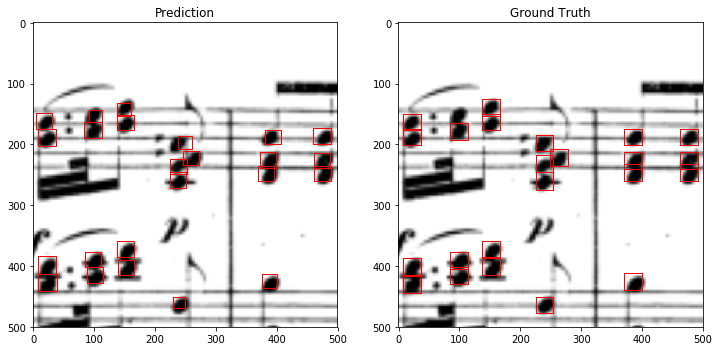

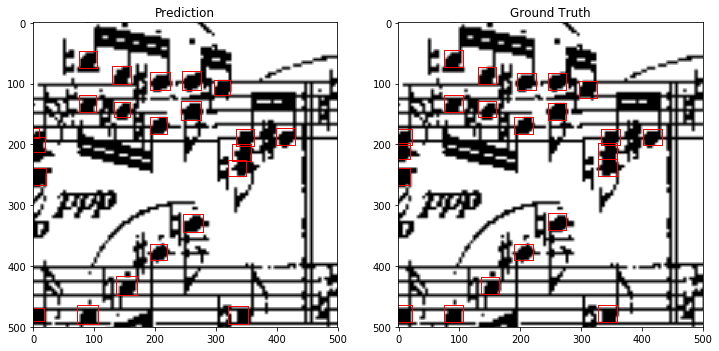

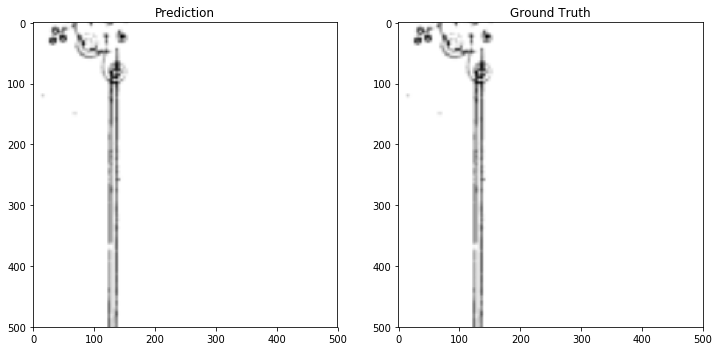

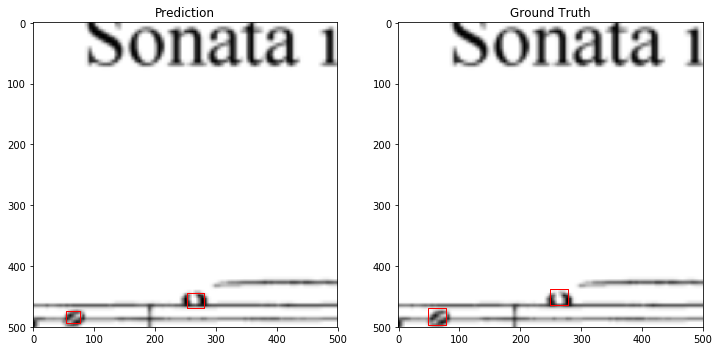

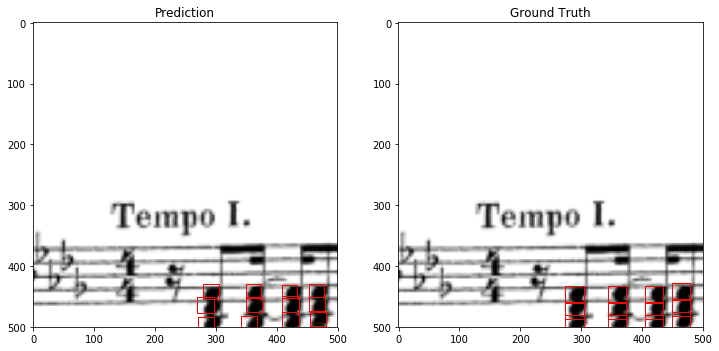

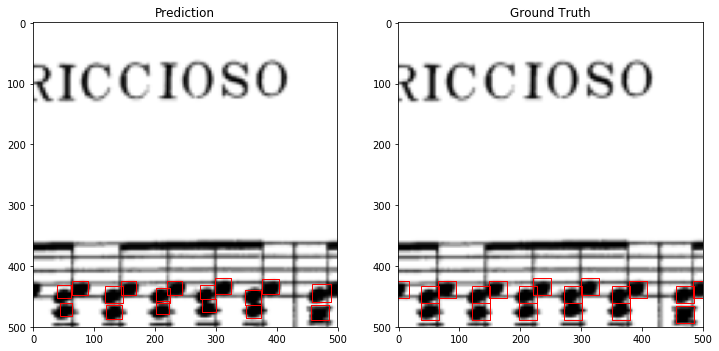

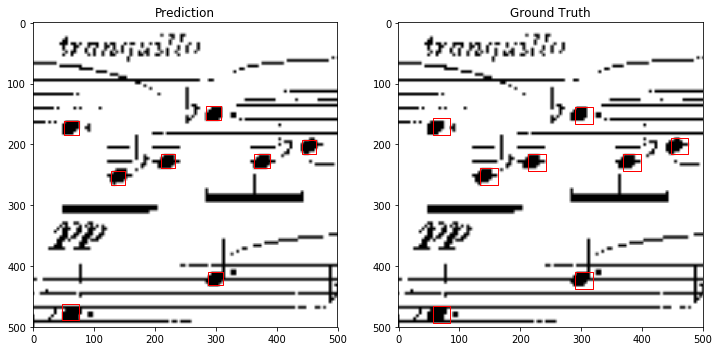

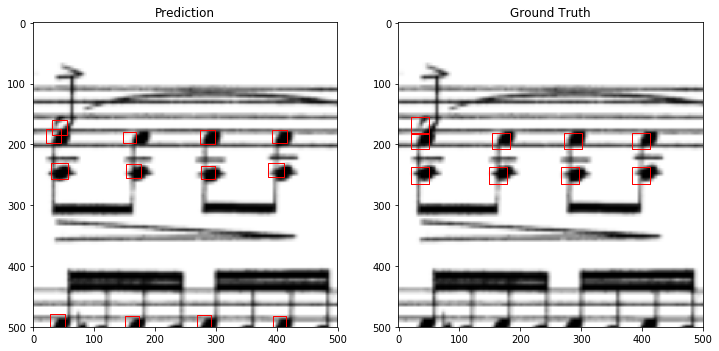

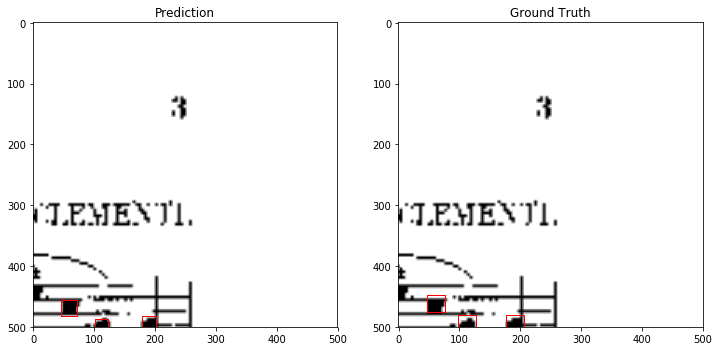

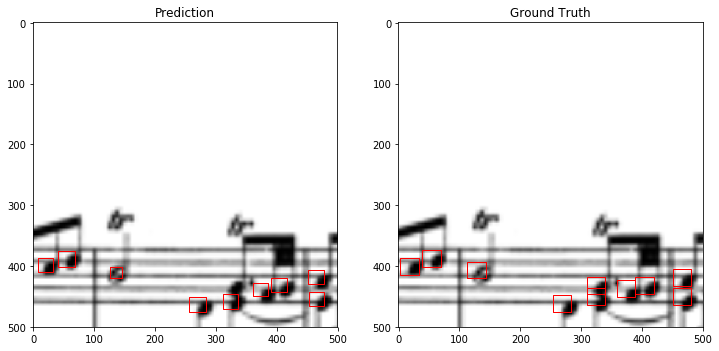

In [19]:
for i in range(10):
    (X,y) = getInput()
    y_pred = dwd_model.predict(X)
    energy_map = np.argmax(y_pred[0], axis=-1)[0]
    energy_map_binarized = 255 * (np.argmax(y_pred[0], axis=-1)[0] < 5) # binarize image

    class_prediction_img = np.argmax(y_pred[1], axis=-1)[0]
    bbox_prediction      = y_pred[2][0,:,:,:]

    labels, out_img = find_connected_comp(energy_map_binarized)

    n_components = len(np.unique(out_img))
    counter = {}
    summation = {}
    center = {}
    class_pred = {}
    bbox = {}
    for label in labels:
        component_id = labels[label]
        if component_id not in counter:
            counter[component_id] = 0
            center[component_id] = (0,0)
            class_pred[component_id] = []
            bbox[component_id] = (0,0)

        counter[component_id] += 1
        center[component_id] = (center[component_id][0] + label[0], center[component_id][1] + label[1])
        class_pred[component_id].append(class_prediction_img[label[0],label[1]])
        bbox[component_id] = (bbox[component_id][0] + bbox_prediction[label[0],label[1],0], bbox[component_id][1] + bbox_prediction[label[0],label[1],1] )

    for center_id in center:
        center[center_id] = (center[center_id][0] / counter[center_id], center[center_id][1] / counter[center_id])
        class_pred[center_id] = max(set(class_pred[center_id]), key = class_pred[center_id].count)
        bbox[center_id] = (bbox[center_id][0] / counter[center_id], bbox[center_id][1] / counter[center_id])

    boxes = []
    # filter prediction boxes
    for idx, obj in enumerate(center.keys()):
        boxes.append([center[obj][1] - bbox[obj][1] / 2, center[obj][0] - bbox[obj][0] / 2, 
                      center[obj][1] + bbox[obj][1] / 2, center[obj][0] + bbox[obj][0] / 2, class_pred[obj]])

    boxes = filterBoxes(boxes, [29, 31])
    boxes = np.array(boxes)
    suppressed_box = non_max_suppression_fast(boxes, 0.25)
    
    scores = []
    for idx in range(len(suppressed_box)):
        center_point_c = int((suppressed_box[idx][0] + suppressed_box[idx][2]) / 2)
        center_point_r = int((suppressed_box[idx][1] + suppressed_box[idx][3]) / 2)
        scores.append(energy_map[center_point_r, center_point_c] / 10)

    gt_boxes[i] = y['bbox']
    pred_boxes[i] = {
        'boxes': [box[:4] for box in suppressed_box] ,
        'scores': scores,
    }
        
    # plot
    img = X[0,:,:,0]
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(img, cmap='gray')

    patches = []
    for box in suppressed_box:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))

    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[0].add_collection(pc)
    ax[0].set_title('Prediction')

    patches = []
    for box in y['bbox']:
        patches.append(Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1]))

    pc = PatchCollection(patches, facecolor='None', edgecolor='r')
    ax[1].add_collection(pc)
    ax[1].set_title('Ground Truth')
    plt.show()    

In [20]:
print("mAP = ", evaluate(gt_boxes, pred_boxes))

mAP =  0.24080908597938308
